<a href="https://colab.research.google.com/github/dgrifka/nfl_motion_coverage_overlap/blob/main/colab/Overlap_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Man vs. Zone Overlap Analysis**

Finally, we're going to analyze how Offense and Defense overlap varies, depending on if the Defense is in Man vs. Zone.

The code for this notebook can be found at https://github.com/dgrifka/nfl_motion_coverage_overlap.

First, we must import the functions necessary.

In [1]:
!git clone https://github.com/dgrifka/nfl_motion_coverage_overlap.git

import os

# Change this to the path of your repository
repo_path = '/content/nfl_motion_coverage_overlap'
os.chdir(repo_path)

# Import the necessary functions
%run setup.py

Cloning into 'nfl_motion_coverage_overlap'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 143 (delta 64), reused 19 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 42.05 MiB | 47.01 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
overlap_df = pl.read_csv('model/zone_man_overlap.csv', null_values=['NA'])
# Ensure there are no duplicate rows
overlap_df = overlap_df.unique(subset=['gameId', 'playId', 'frameId'], keep='first')
overlap_df.head()

gameId,playId,frameId,iou,overlap_coefficient,weighted_overlap,pff_manZone
i64,i64,i64,f64,f64,f64,str
2022101601,1919,188,0.323759,0.509477,0.66429,"""Man"""
2022100211,1855,111,0.238987,0.491729,0.500191,"""Zone"""
2022101611,1879,69,0.138065,0.258883,0.240901,"""Man"""
2022101611,1879,111,0.213263,0.401932,0.462469,"""Man"""
2022100901,254,123,0.238752,0.60418,0.461966,"""Zone"""


First, let's make sure we have a similar number of Man and Zone plays, while checking their average weighted overlap.

In [3]:
# Count plays by defense type
result = (
    overlap_df
    .group_by('pff_manZone')
    .agg([
        pl.struct(['gameId', 'playId']).n_unique().alias('unique_play_count'),
        pl.col('weighted_overlap').mean().alias('avg_weighted_overlap')
    ])
    .sort('pff_manZone')
)
print(result)

shape: (2, 3)
┌─────────────┬───────────────────┬──────────────────────┐
│ pff_manZone ┆ unique_play_count ┆ avg_weighted_overlap │
│ ---         ┆ ---               ┆ ---                  │
│ str         ┆ u32               ┆ f64                  │
╞═════════════╪═══════════════════╪══════════════════════╡
│ Man         ┆ 116               ┆ 0.504907             │
│ Zone        ┆ 117               ┆ 0.382433             │
└─────────────┴───────────────────┴──────────────────────┘


To better understand the differences between Man and Zone, let's plot the distribution of weighted_overlap values for each Defense type.

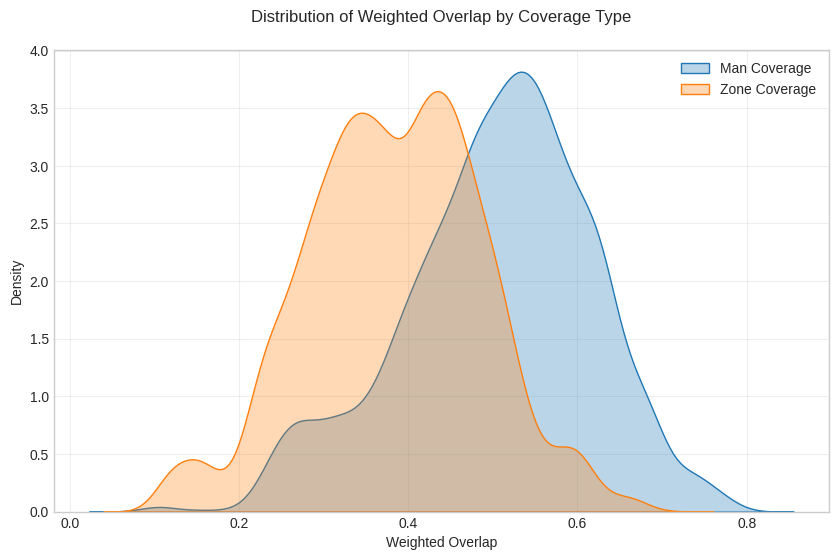

In [4]:
# For the original weighted_overlap distribution
plot_overlap_distribution(overlap_df)

Next, let's look at the change in overlap of each subsequent frame.

In [5]:
# Calculate both directional and absolute changes
overlap_changes = (
    overlap_df
    .sort(['gameId', 'playId', 'frameId'])  # Ensure proper ordering
    .group_by(['gameId', 'playId', 'pff_manZone'])
    .agg([
        # Original directional change
        pl.col('weighted_overlap').diff().alias('overlap_delta'),
        # Absolute change
        pl.col('weighted_overlap').diff().abs().alias('absolute_overlap_delta'),
        # Get std dev of both
        pl.col('weighted_overlap').diff().std().alias('directional_volatility'),
        pl.col('weighted_overlap').diff().abs().std().alias('absolute_volatility')
    ])
)

overlap_changes.head()

gameId,playId,pff_manZone,overlap_delta,absolute_overlap_delta,directional_volatility,absolute_volatility
i64,i64,str,list[f64],list[f64],f64,f64
2022092502,3273,"""Man""","[null, -0.013601, … -0.022779]","[null, 0.013601, … 0.022779]",0.020081,0.01114
2022110601,1791,"""Zone""","[null, 0.015059, … -0.009995]","[null, 0.015059, … 0.009995]",0.016009,0.008454
2022100905,3407,"""Man""","[null, 0.014531, … 0.013035]","[null, 0.014531, … 0.013035]",0.017243,0.009387
2022091810,3549,"""Man""","[null, -0.00327, … -0.012089]","[null, 0.00327, … 0.012089]",0.021057,0.011104
2022091103,3505,"""Man""","[null, 0.011016, … -0.003433]","[null, 0.011016, … 0.003433]",0.02226,0.01327


Then, let's check the distributions of the changes.

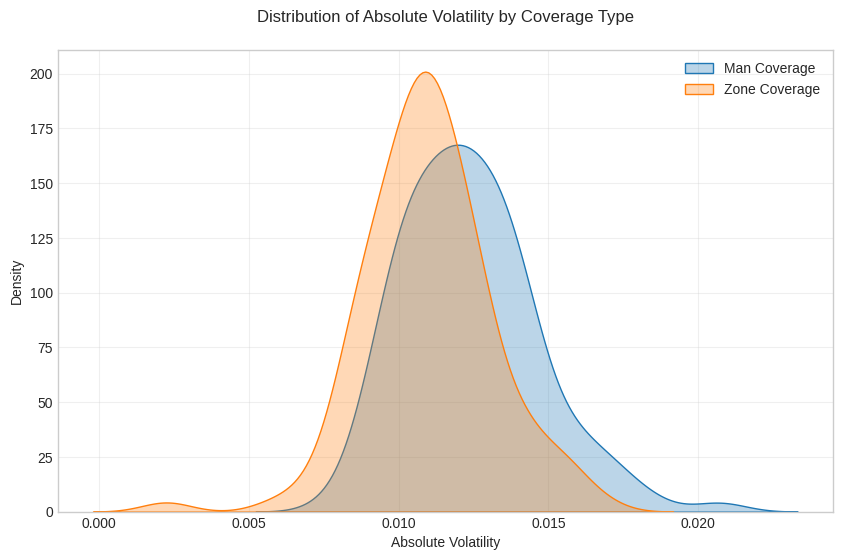

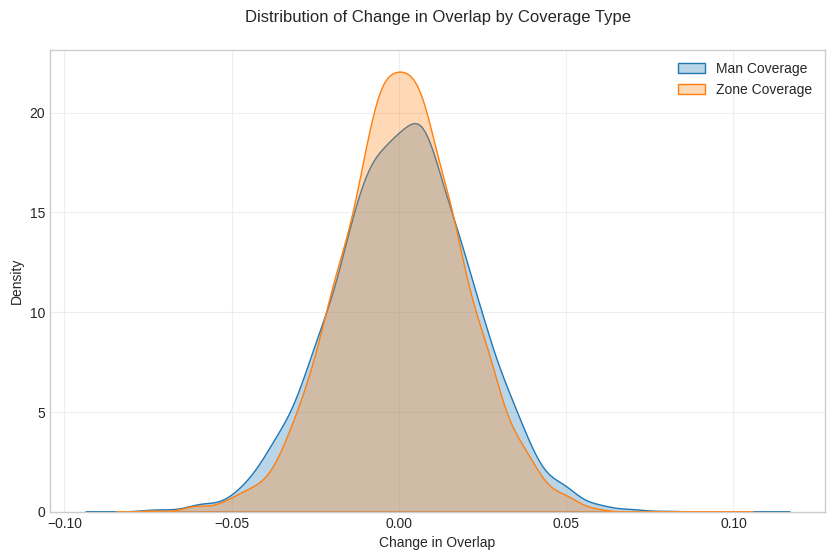

In [6]:
# For change metrics
plot_changes_distribution(overlap_changes, "absolute_volatility")  # For regular columns
plot_changes_distribution(overlap_changes, "overlap_delta", handle_lists=True)  # For list columns

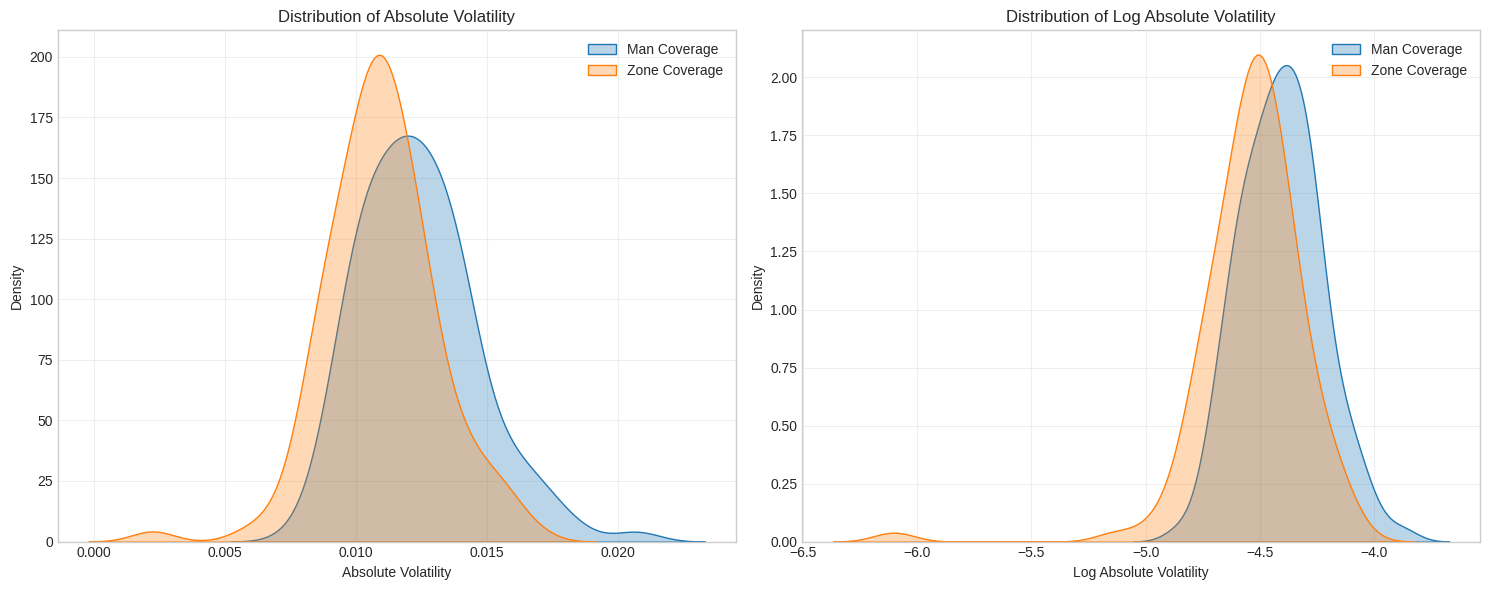

In [7]:
plot_volatility_distributions(overlap_changes)

To determine if there is a reasonable difference between the two Defense types, we will resort to Bayesian methods.

# Bayesian Volatility Analysis Model

## Bayesian Volatility Analysis Model

For coverage type $i \in \{\text{Man}, \text{Zone}\}$:

### Prior Distributions
$\mu_{\text{Man}} \sim \mathcal{N}(-4.5, 1)$

$\sigma_{\text{Man}} \sim \text{HalfNormal}(0.5)$

$\mu_{\text{Zone}} \sim \mathcal{N}(-4.5, 1)$

$\sigma_{\text{Zone}} \sim \text{HalfNormal}(0.5)$

### Likelihood
$\log(\text{Volatility}_{\text{Man}}) \sim \mathcal{N}(\mu_{\text{Man}}, \sigma_{\text{Man}})$

$\log(\text{Volatility}_{\text{Zone}}) \sim \mathcal{N}(\mu_{\text{Zone}}, \sigma_{\text{Zone}})$

### Derived Quantities
$\text{Mean}_{\text{Man}} = \exp(\mu_{\text{Man}})$

$\text{Mean}_{\text{Zone}} = \exp(\mu_{\text{Zone}})$

$\text{Difference} = \text{Mean}_{\text{Man}} - \text{Mean}_{\text{Zone}}$

Output()


Probability that Man coverage has higher volatility: 1.0

Summary of posterior distributions:
             mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
man_mean    0.012  0.0   0.012    0.013        0.0      0.0   13764.0   
zone_mean   0.011  0.0   0.010    0.011        0.0      0.0   12996.0   
difference  0.001  0.0   0.001    0.002        0.0      0.0   12917.0   

            ess_tail  r_hat  
man_mean      6737.0    1.0  
zone_mean     6006.0    1.0  
difference    6901.0    1.0  


array([[<Axes: title={'center': 'man_mean'}>,
        <Axes: title={'center': 'man_mean'}>],
       [<Axes: title={'center': 'zone_mean'}>,
        <Axes: title={'center': 'zone_mean'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'difference'}>]], dtype=object)

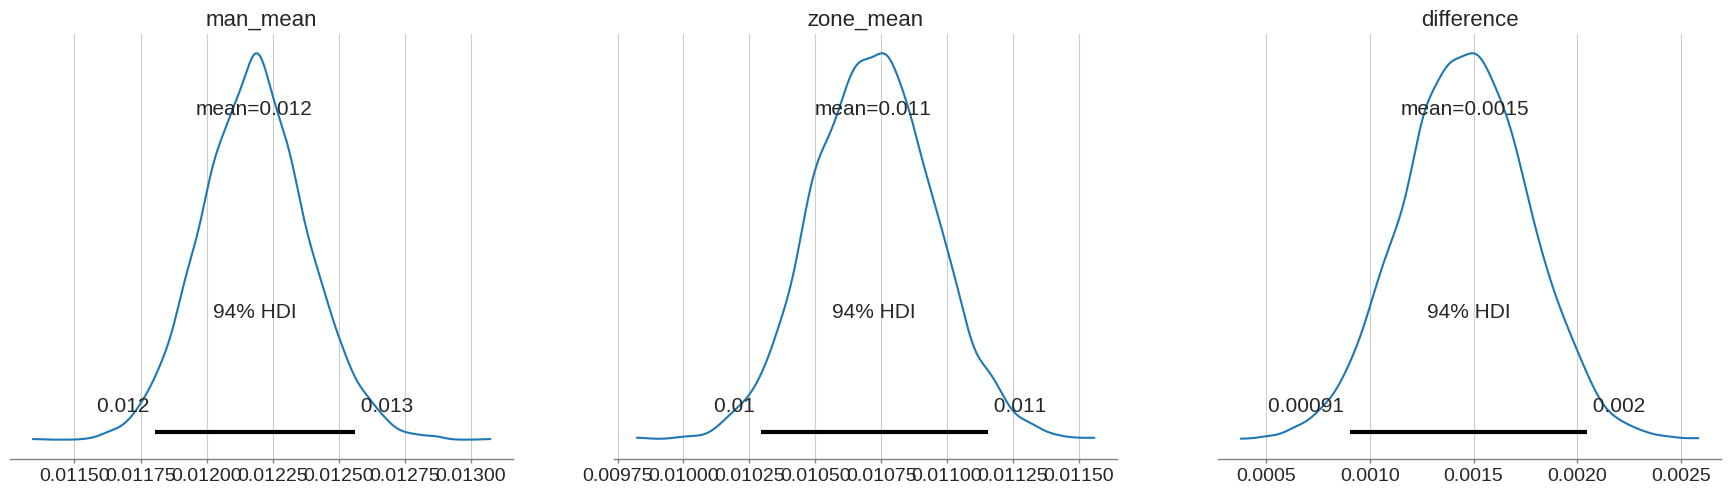

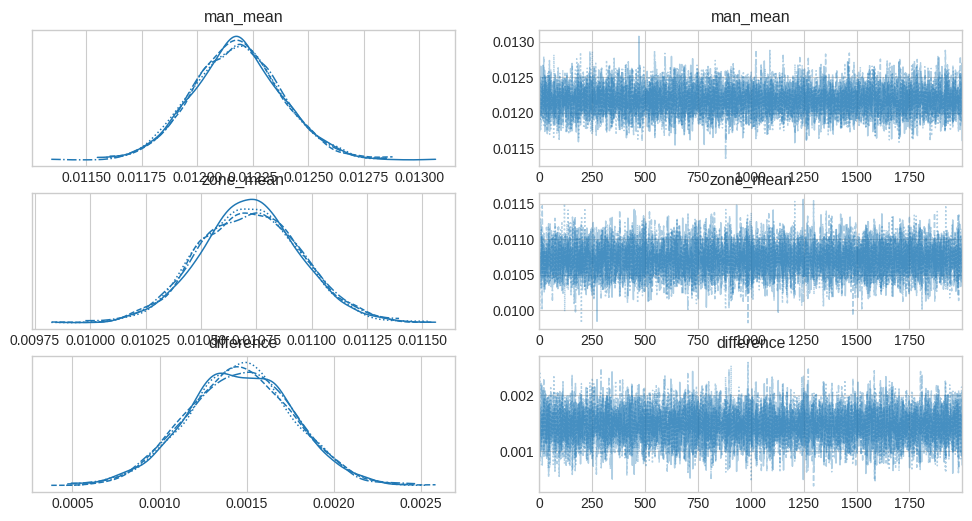

In [8]:
# First, let's prepare our data
man_volatility = overlap_changes.filter(pl.col('pff_manZone') == 'Man')['absolute_volatility'].to_numpy()
zone_volatility = overlap_changes.filter(pl.col('pff_manZone') == 'Zone')['absolute_volatility'].to_numpy()

# Create and fit Bayesian model
with pm.Model() as volatility_model:

    # Take log of data
    log_man_volatility = np.log(man_volatility)
    log_zone_volatility = np.log(zone_volatility)

    # Parameters for each coverage type
    man_mu = pm.Normal('man_mu', mu=-4.5, sigma=1)
    man_sigma = pm.HalfNormal('man_sigma', sigma=0.5)

    zone_mu = pm.Normal('zone_mu', mu=-4.5, sigma=1)
    zone_sigma = pm.HalfNormal('zone_sigma', sigma=0.5)

    # Likelihood using Normal distribution
    man_likelihood = pm.Normal('man', mu=man_mu, sigma=man_sigma,
                             observed=log_man_volatility)
    zone_likelihood = pm.Normal('zone', mu=zone_mu, sigma=zone_sigma,
                              observed=log_zone_volatility)

    # Transform back to original scale if needed
    man_mean = pm.Deterministic('man_mean', pm.math.exp(man_mu))
    zone_mean = pm.Deterministic('zone_mean', pm.math.exp(zone_mu))

    difference = pm.Deterministic('difference', man_mean - zone_mean)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Calculate probability that Man coverage has higher volatility
prob_man_higher = (trace.posterior['difference'] > 0).mean().item()

# Get summary statistics
summary = az.summary(trace, var_names=['man_mean', 'zone_mean', 'difference'])

print("\nProbability that Man coverage has higher volatility:", prob_man_higher)
print("\nSummary of posterior distributions:")
print(summary)

# Plot posterior distributions
az.plot_posterior(trace, var_names=['man_mean', 'zone_mean', 'difference'])

# Add trace plot
az.plot_trace(trace, var_names=['man_mean', 'zone_mean', 'difference'])

# Bayesian Delta Analysis Model

## Bayesian Delta Analysis Model

### Prior Distributions
$\sigma_{\text{Man}} \sim \text{HalfNormal}(0.1)$

$\sigma_{\text{Zone}} \sim \text{HalfNormal}(0.1)$

$\mu_{\text{Man}} \sim \mathcal{N}(0, 0.1)$

$\mu_{\text{Zone}} \sim \mathcal{N}(0, 0.1)$

### Likelihood
$\Delta_{\text{Man}} \sim \mathcal{N}(\mu_{\text{Man}}, \sigma_{\text{Man}})$

$\Delta_{\text{Zone}} \sim \mathcal{N}(\mu_{\text{Zone}}, \sigma_{\text{Zone}})$

### Derived Quantity
$\text{Difference} = \mu_{\text{Man}} - \mu_{\text{Zone}}$

Output()


Probability that Zone coverage has more negative deltas: 0.9215

Summary of posterior distributions:
             mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
man_mean    0.001  0.0   0.001    0.002        0.0      0.0   13014.0   
zone_mean   0.001  0.0   0.000    0.001        0.0      0.0   13687.0   
difference  0.000  0.0  -0.000    0.001        0.0      0.0   13147.0   

            ess_tail  r_hat  
man_mean      6771.0    1.0  
zone_mean     6932.0    1.0  
difference    6654.0    1.0  


array([[<Axes: title={'center': 'man_mean'}>,
        <Axes: title={'center': 'man_mean'}>],
       [<Axes: title={'center': 'zone_mean'}>,
        <Axes: title={'center': 'zone_mean'}>],
       [<Axes: title={'center': 'difference'}>,
        <Axes: title={'center': 'difference'}>]], dtype=object)

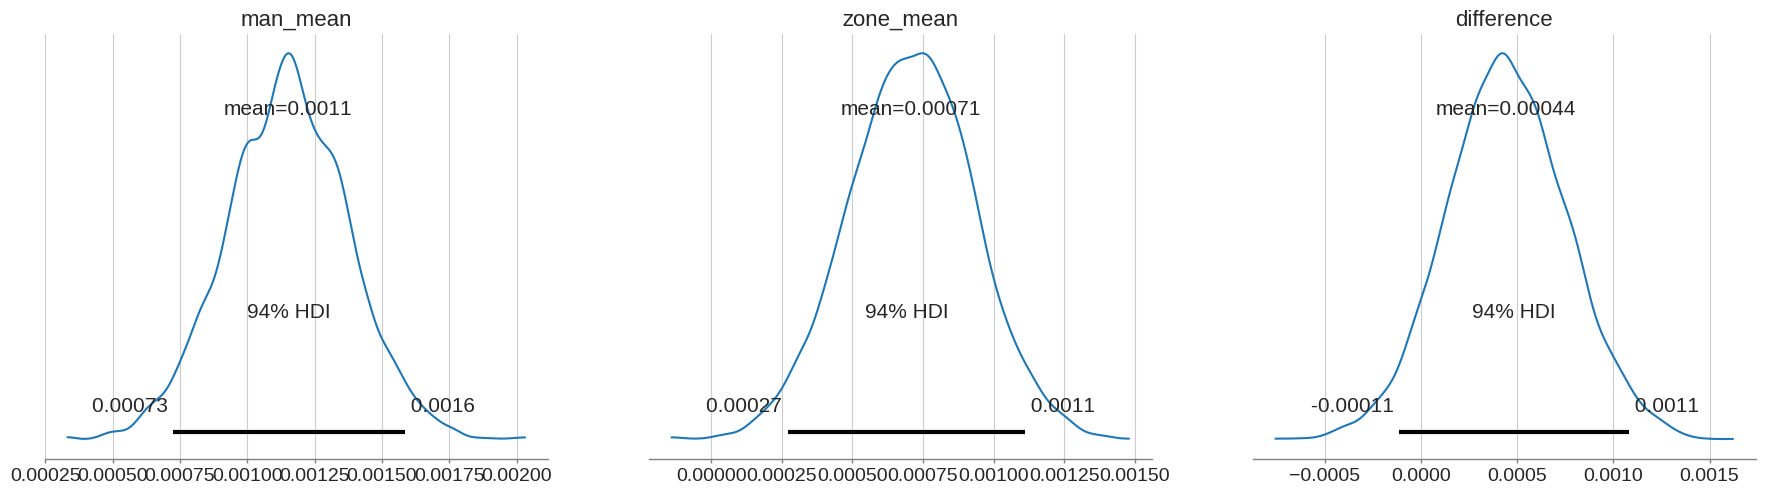

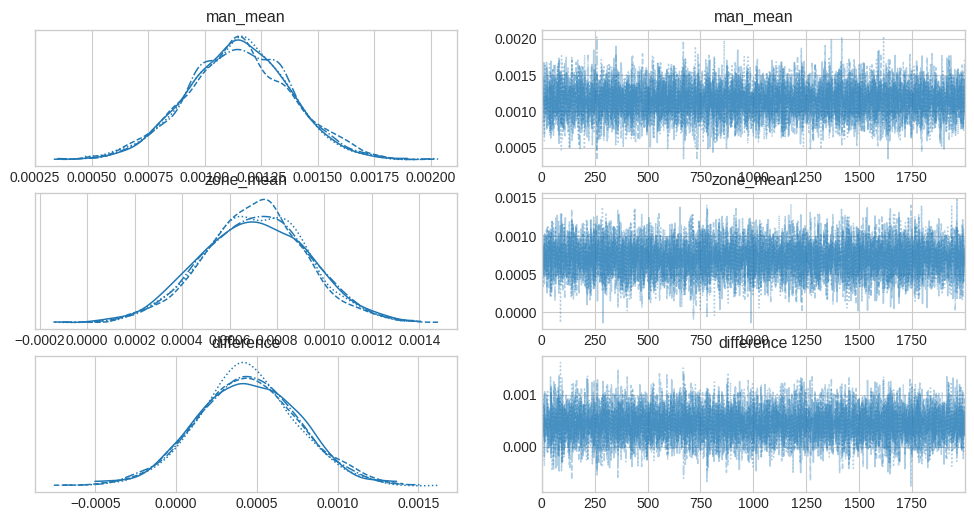

In [9]:
# Prepare the data by flattening the lists of deltas
man_deltas = []
zone_deltas = []

# Extract and flatten the delta lists for each coverage type
for row in overlap_changes.iter_rows():
    # Get pff_manZone and overlap_delta values
    coverage = row[overlap_changes.columns.index('pff_manZone')]
    deltas = row[overlap_changes.columns.index('overlap_delta')]

    # Remove the null value (first frame) and extend the appropriate list
    deltas_clean = [d for d in deltas if d is not None]
    if coverage == 'Man':
        man_deltas.extend(deltas_clean)
    else:  # Zone
        zone_deltas.extend(deltas_clean)

# Convert to numpy arrays
man_delta = np.array(man_deltas)
zone_delta = np.array(zone_deltas)

# Create and fit Bayesian model
with pm.Model() as delta_model:
    # Priors for each coverage type
    # Using normal distribution since delta can be positive or negative
    man_std = pm.HalfNormal('man_std', sigma=0.1)
    zone_std = pm.HalfNormal('zone_std', sigma=0.1)

    # Mean delta for each coverage type
    # Using wider prior since we don't know the direction of effect
    man_mean = pm.Normal('man_mean', mu=0, sigma=0.1)
    zone_mean = pm.Normal('zone_mean', mu=0, sigma=0.1)

    # Likelihood for each coverage type
    man_likelihood = pm.Normal('man', mu=man_mean, sigma=man_std, observed=man_delta)
    zone_likelihood = pm.Normal('zone', mu=zone_mean, sigma=zone_std, observed=zone_delta)

    # Calculate the difference between coverages (Man - Zone)
    # Positive difference means Man has larger (less negative) deltas
    difference = pm.Deterministic('difference', man_mean - zone_mean)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Calculate probability that Zone has more negative deltas
prob_zone_more_negative = (trace.posterior['difference'] > 0).mean().item()

# Get summary statistics
summary = az.summary(trace, var_names=['man_mean', 'zone_mean', 'difference'])

print("\nProbability that Zone coverage has more negative deltas:", prob_zone_more_negative)
print("\nSummary of posterior distributions:")
print(summary)

# Plot posterior distributions
az.plot_posterior(trace, var_names=['man_mean', 'zone_mean', 'difference'])

# Add trace plot
az.plot_trace(trace, var_names=['man_mean', 'zone_mean', 'difference'])

In order to find certain plays reacting to Defensive coverage, then use the code below.

In [10]:
# Create filtered dataframes for Man and Zone coverage
# Sorted by absolute_volatility descending
man_volatile_desc = filter_and_sort_overlaps(overlap_changes,
                                           'Man',
                                           'absolute_volatility',
                                           ascending=False)
zone_volatile_desc = filter_and_sort_overlaps(overlap_changes,
                                            'Zone',
                                            'absolute_volatility',
                                            ascending=False)

# Sorted by absolute_volatility ascending
man_volatile_asc = filter_and_sort_overlaps(overlap_changes,
                                          'Man',
                                          'absolute_volatility',
                                          ascending=True)
zone_volatile_asc = filter_and_sort_overlaps(overlap_changes,
                                           'Zone',
                                           'absolute_volatility',
                                           ascending=True)

# Create dataframes with total_delta calculations
man_delta_desc = calculate_total_delta(overlap_changes, 'Man', ascending=False)
man_delta_asc = calculate_total_delta(overlap_changes, 'Man', ascending=True)
zone_delta_desc = calculate_total_delta(overlap_changes, 'Zone', ascending=False)
zone_delta_asc = calculate_total_delta(overlap_changes, 'Zone', ascending=True)

In [11]:
print("Man Coverage - Most Volatile:")
print(man_volatile_desc)
print("\nZone Coverage - Most Volatile:")
print(zone_volatile_desc)
print("\nMan Coverage - Least Volatile:")
print(man_volatile_asc)
print("\nZone Coverage - Least Volatile:")
print(zone_volatile_asc)
print("\nMan Coverage - Highest Total Delta:")
print(man_delta_desc)
print("\nMan Coverage - Lowest Total Delta:")
print(man_delta_asc)
print("\nZone Coverage - Highest Total Delta:")
print(zone_delta_desc)
print("\nZone Coverage - Lowest Total Delta:")
print(zone_delta_asc)

Man Coverage - Most Volatile:
shape: (3, 7)
┌────────────┬────────┬─────────────┬───────────────┬───────────────┬───────────────┬──────────────┐
│ gameId     ┆ playId ┆ pff_manZone ┆ overlap_delta ┆ absolute_over ┆ directional_v ┆ absolute_vol │
│ ---        ┆ ---    ┆ ---         ┆ ---           ┆ lap_delta     ┆ olatility     ┆ atility      │
│ i64        ┆ i64    ┆ str         ┆ list[f64]     ┆ ---           ┆ ---           ┆ ---          │
│            ┆        ┆             ┆               ┆ list[f64]     ┆ f64           ┆ f64          │
╞════════════╪════════╪═════════════╪═══════════════╪═══════════════╪═══════════════╪══════════════╡
│ 2022091110 ┆ 2869   ┆ Man         ┆ [null,        ┆ [null,        ┆ 0.033378      ┆ 0.020716     │
│            ┆        ┆             ┆ 0.017993, …   ┆ 0.017993, …   ┆               ┆              │
│            ┆        ┆             ┆ 0.026574]     ┆ 0.026574]     ┆               ┆              │
│ 2022101601 ┆ 2216   ┆ Man         ┆ [null,   

---

Incorporate Team information